## vanilla-DNN

Author: Justin Tan

Vanilla neural network. Do anything from MNIST to signal classification.

Update 20/03: Added batch normalization, TensorBoard visualization

Update 19/06: Added cosine annealing, exponential moving average

Update 22/09: Moved input pipeline to tfrecords

In [1]:
!nvidia-smi

Fri Sep 22 21:01:47 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.66                 Driver Version: 384.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:05:00.0 Off |                    0 |
| N/A   45C    P0    58W / 149W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:06:00.0 Off |                    0 |
| N/A   38C    P0    73W / 149W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import glob, time, os

import selu
from diagnostics import *
from gpu_ops import *

class config(object):
    # Set network parameters
    mode = 'pi0veto'
    channel = 'Bu2Xsy'
    nFeatures = 44
    keep_prob = 0.72
    num_epochs = 16
    batch_size = 512
    n_layers = 5
    hidden_layer_nodes = [1024, 1024, 512, 512, 256]
    ema_decay = 0.999
    learning_rate = 1e-4
    cycles = 8 # Number of annealing cycles
    n_classes = 2
    n_gpus = 4
    builder = 'selu'

class directories(object):
    train = '/data/projects/punim0011/jtan/spark/spark2tf/sc_train.parquet'# '/home/jtan/gpu/jtan/spark/spark2tf/example_train.tfrecords'
    test = '/data/projects/punim0011/jtan/spark/spark2tf/sc_test.parquet'# '/home/jtan/gpu/jtan/spark/spark2tf/example_test.tfrecords'
    tensorboard = 'tensorboard'
    checkpoints = 'checkpoints'

def load_parquet(datasetName):
    excludeFeatures = ['labels', 'mbc', 'deltae']
    dataset = pq.ParquetDataset(datasetName)
    pdf = dataset.read(nthreads=4).to_pandas()
    features = pdf.drop(excludeFeatures, axis=1)
    labels = pdf['labels'].astype(np.int32)
    
    return features.values, labels.values

assert config.batch_size%config.n_gpus == 0, 'Batch size must be divisble by the number of gpus'
architecture = '{} - {} | Layers: {} | Dropout: {} | Base LR: {} | Epochs: {}'.format(
    config.channel, config.mode, config.n_layers, config.keep_prob, config.learning_rate, config.num_epochs)

features, labels = load_parquet(directories.train)
featuresTest, labelsTest = load_parquet(directories.test)
config.nTrainExamples, config.nFeatures = features.shape[0], features.shape[-1]
config.steps_per_epoch = features.shape[0] // config.batch_size
get_available_gpus()

Available GPUs:
['/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3']


### Functions for graph construction

In [2]:
def dataset_placeholder(features_placeholder, labels_placeholder, batchSize, numEpochs, training=True):  
    dataset = tf.contrib.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))
    dataset = dataset.shuffle(buffer_size=16384)
    dataset = dataset.batch(batchSize)
    dataset = dataset.repeat(numEpochs) if training else dataset

    return dataset

def dataset_train(dataDirectory, batchSize, numEpochs, nFeatures, training=True):
    filenames = glob.glob('{}/part*'.format(dataDirectory))
    dataset = tf.contrib.data.TFRecordDataset(filenames)

    # Extract data from `tf.Example` protocol buffer
    def parser(record, batchSize=128):
        keys_to_features = {
            "features": tf.FixedLenFeature([nFeatures], tf.float32),
            "labels": tf.FixedLenFeature((), tf.float32,
            default_value=tf.zeros([], dtype=tf.float32)),
        }
        parsed = tf.parse_single_example(record, keys_to_features)
        label = tf.cast(parsed['labels'], tf.int32)

        return parsed['features'], label

    # Transform into feature, label tensor pair
    dataset = dataset.map(parser)
    dataset = dataset.shuffle(buffer_size=16384)
    dataset = dataset.batch(batchSize)
    dataset = dataset.repeat(numEpochs) if training else dataset

    return dataset

def dense_builder(x, shape, name, keep_prob, training=True, actv=tf.nn.relu):
    init=tf.contrib.layers.xavier_initializer()
    kwargs = {'center': True, 'scale': True, 'training': training, 'fused': True, 'renorm': True}

    with tf.variable_scope(name, initializer=init) as scope:
        layer = tf.layers.dense(x, units=shape[1], activation=actv)
        bn = tf.layers.batch_normalization(layer, **kwargs)
        layer_out = tf.layers.dropout(bn, keep_prob, training=training)

    return layer_out

def selu_builder(x, shape, name, keep_prob, training=True):
    init = tf.contrib.layers.variance_scaling_initializer(factor=1.0, mode='FAN_IN')

    with tf.variable_scope(name) as scope:
        W = tf.get_variable("weights", shape = shape, initializer=init)
        b = tf.get_variable("biases", shape = [shape[1]], initializer=tf.random_normal_initializer(stddev=0.1))
        actv = selu.selu(tf.add(tf.matmul(x, W), b))
        layer_output = selu.dropout_selu(actv, rate=1-keep_prob, training=training)

    return layer_output

def dense_model(x, n_layers, hidden_layer_nodes, keep_prob, builder=selu_builder, reuse=False, training=True):
    # Extensible dense model
    print('Building computation graph')
    SELU_initializer = tf.contrib.layers.variance_scaling_initializer(factor=1.0, mode='FAN_IN')
    init = SELU_initializer if builder==selu_builder else tf.contrib.layers.xavier_initializer()
    assert n_layers == len(hidden_layer_nodes), 'Specified layer nodes and number of layers do not correspond.'
    layers = [x]

    with tf.variable_scope('dense_model', reuse=reuse):
        hidden_0 = builder(x, shape=[config.nFeatures, hidden_layer_nodes[0]], name='hidden0',
                                keep_prob = keep_prob, training=training)
        layers.append(hidden_0)
        for n in range(0,n_layers-1):
            hidden_n = builder(layers[-1], shape=[hidden_layer_nodes[n], hidden_layer_nodes[n+1]], name='hidden{}'.format(n+1),
                                keep_prob=keep_prob, training=training)
            layers.append(hidden_n)

        readout = tf.layers.dense(hidden_n, units=config.n_classes, kernel_initializer=init)

    return readout

def cosine_anneal(initial_lr, t, T, M):
    from math import ceil
    beta = initial_lr/2 * (np.cos(np.pi* (t % ceil(T/M))/ceil(T/M)) + 1)
    return beta

In [5]:
class vanillaDNN():
    # Builds the computational graph
    def __init__(self, config, training=True, cyclical=False):
        
        self.global_step = tf.Variable(0, trainable=False)
        self.handle = tf.placeholder(tf.string, shape=[])
        self.training_phase = tf.placeholder(tf.bool)
        self.beta = tf.placeholder(tf.float32) if cyclical else config.learning_rate
#         self.beta = tf.train.exponential_decay(config.learning_rate, self.global_step, 
#                                                decay_steps = config.steps_per_epoch, decay_rate = config.lr_epoch_decay, staircase=True)
         
        # Feedable iterator defined by handle placeholder and structure.
        self.features_placeholder = tf.placeholder(features.dtype, features.shape)
        self.labels_placeholder = tf.placeholder(labels.dtype, labels.shape)
        self.featuresTest_placeholder = tf.placeholder(features.dtype, featuresTest.shape)
        self.labelsTest_placeholder = tf.placeholder(labels.dtype, labelsTest.shape)

        trainDataset = dataset_placeholder(self.features_placeholder, self.labels_placeholder, 
                                           int(config.batch_size/config.n_gpus), config.num_epochs, training=True)
        testDataset = dataset_placeholder(self.featuresTest_placeholder, self.labelsTest_placeholder, 
                                          int(config.batch_size/config.n_gpus), config.num_epochs, training=True)
        
        self.iterator = tf.contrib.data.Iterator.from_string_handle(self.handle, trainDataset.output_types, 
                                                               trainDataset.output_shapes)

        self.train_iterator = trainDataset.make_initializable_iterator()
        self.test_iterator = testDataset.make_initializable_iterator()
        
        opt = tf.train.AdamOptimizer(self.beta)
#         self.examples, labels = self.iterator.get_next()
        
#         example_batches = tf.split(self.examples, config.n_gpus, axis = 0)
#         label_batches = tf.split(labels, config.n_gpus, axis = 0)
        # Calculate gradients for each model tower
        tower = {'grads': [], 'readouts': [], 'summaries': [],
                 'losses': [], 'labels': []}
        for gpu in range(config.n_gpus):
            with tf.device('/gpu:{}'.format(gpu)):
                with tf.variable_scope('vDNN', reuse=(gpu > 0)):
                    with tf.name_scope('tower_{}'.format(gpu)) as scope:
                        # Load one batch per GPU
                        example_batch, label_batch = self.iterator.get_next()

                        # Calculate loss for one tower of the model. Construct the entire model,
                        # but share the variable across all towers
                        loss, readout = tower_computation(dense_model, config, scope, example_batch, label_batch, self.training_phase, gpu)
                        # Retain the summaries from the final tower.
                        summaries = tf.get_collection(tf.GraphKeys.SUMMARIES, scope)

                        # Retain batch norm update operations only from the final tower.
                        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope)

                        # Calculate the gradients for given batch on this tower
                        grads = opt.compute_gradients(loss)
                        tower['grads'].append(grads)
                        tower['readouts'].append(readout)
                        tower['summaries'].append(summaries)
                        tower['losses'].append(loss)
                        tower['labels'].append(label_batch)
        
        # Synchronize all towers
        mean_grads = average_gradients(tower['grads'])
        self.readout = tf.concat(tower['readouts'], axis=0)
        self.labels = tf.concat(tower['labels'], axis=0)
        
        # Evaluation metrics
        self.cross_entropy = tf.reduce_mean(tower['losses'])
        self.p = tf.nn.softmax(self.readout)
        correct_prediction = tf.equal(tf.cast(tf.argmax(self.readout, 1), tf.int32), self.labels)
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        _, self.auc_op = tf.metrics.auc(predictions=tf.argmax(self.readout,1), labels=self.labels, num_thresholds=1024)
        
        # Track moving average of trainable variables
        self.ema = tf.train.ExponentialMovingAverage(decay=config.ema_decay, num_updates=self.global_step)
        maintain_averages_op = self.ema.apply(tf.trainable_variables())
        
        # Apply the gradients to adjust the shared variables.
        #with tf.control_dependencies(update_ops):
        apply_gradient_op = opt.apply_gradients(mean_grads, global_step=self.global_step)
        
        # Group all updates to into a single train op.
        # batchnorm_updates_op = tf.group(*batchnorm_updates)
        self.train_op = tf.group(apply_gradient_op, maintain_averages_op)#, batchnorm_updates_op)
        
        # Build the summary operation across tower summaries
        tower['summaries'].append(tf.summary.scalar('cross_entropy', self.cross_entropy))
        tower['summaries'].append(tf.summary.scalar('accuracy', self.accuracy))
        tower['summaries'].append(tf.summary.scalar('auc', self.auc_op))
        tower['summaries'].append(tf.summary.scalar('learning_rate', self.beta))
        self.merge_op = tf.summary.merge(tower['summaries'])
        
        self.train_writer = tf.summary.FileWriter(
            os.path.join(directories.tensorboard, 'multiGPUtrain_{}'.format(time.strftime('%d-%m_%I:%M'))), graph = tf.get_default_graph())
        self.test_writer = tf.summary.FileWriter(
            os.path.join(directories.tensorboard, 'multiGPUtest_{}'.format(time.strftime('%d-%m_%I:%M'))))

    def predict(self, ckpt):
        pin_cpu = tf.ConfigProto(allow_soft_placement=True, log_device_placement=True, device_count = {'GPU':0})
        start_time = time.time()
        
        # Restore the moving average version of the learned variables for eval.
        variables_to_restore = self.ema.variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)
        valDataset = dataset_train(directories.test, batchSize=config.batch_size, numEpochs=config.num_epochs, 
                                    nFeatures=config.nFeatures, training=False)

        val_iterator = valDataset.make_one_shot_iterator()
        concatLabels = tf.cast(self.label, tf.int32)
        concatPreds = tf.cast(tf.argmax(self.readout,1), tf.int32)
        concatOutput = self.p[:,1]

        with tf.Session(config=pin_cpu) as sess:
            # Initialize variables
            init_op = tf.global_variables_initializer()
            sess.run(init_op)
            sess.run(tf.local_variables_initializer())
            assert (ckpt.model_checkpoint_path), 'Missing checkpoint file!'    
            saver.restore(sess, ckpt.model_checkpoint_path)
            print('{} restored.'.format(ckpt.model_checkpoint_path))
            val_handle = sess.run(val_iterator.string_handle())
            labels, preds, outputs = [], [], []
            while True:
                try:
                    l, p, o = sess.run([concatLabels, concatPreds, concatOutput], 
                                       feed_dict = {vDNN.training_phase: False, vDNN.handle: val_handle})
                    labels.append(l), preds.append(p), outputs.append(o)
                except tf.errors.OutOfRangeError:
                    labels, preds, outputs = np.concatenate(labels), np.concatenate(preds), np.concatenate(outputs)
                    break
            acc = np.mean(np.equal(labels,preds))
            print("Validation accuracy: {:.3f}".format(acc))
            
            plot_ROC_curve(network_output=outputs, y_true=labels, identifier=config.mode+config.channel,
                           meta=architecture + ' | Test accuracy: {:.3f}'.format(acc))
            delta_t = time.time() - start_time
            print("Inference complete. Duration: %g s" %(delta_t))
            
            return labels, preds, outputs

In [6]:
def train(config, restore = False):
    # Executes training operations
    print('Architecture: {}'.format(architecture))
    vDNN = vanillaDNN(config, training=True)
    start_time = time.time()
    global_step, n_checkpoints, v_auc_best = 0, 0, 0.
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(directories.checkpoints)

    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
        # Initialize variables
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        train_handle = sess.run(vDNN.train_iterator.string_handle())
        test_handle = sess.run(vDNN.test_iterator.string_handle())
        
        if restore and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
            print('{} restored.'.format(ckpt.model_checkpoint_path))
        
        sess.run(vDNN.train_iterator.initializer, feed_dict={vDNN.features_placeholder: features,
                                                             vDNN.labels_placeholder: labels})
        sess.run(vDNN.test_iterator.initializer, feed_dict={vDNN.featuresTest_placeholder: featuresTest,
                                                             vDNN.labelsTest_placeholder: labelsTest})
        while True:
            try:
                # Run X steps on training dataset
                sess.run(vDNN.train_op, feed_dict = {vDNN.training_phase: True, vDNN.handle: train_handle})
                global_step+=1

                # Single pass over validation dataset
                if global_step % (config.steps_per_epoch // 5) == 0:
                    epoch, v_auc_best = run_diagnostics(vDNN, config, directories, sess, saver, train_handle, test_handle, 
                                                        global_step, config.nTrainExamples, start_time, v_auc_best, n_checkpoints)
                    
            except tf.errors.OutOfRangeError:
                break

        save_path = saver.save(sess, os.path.join(directories.checkpoints, 'vDNN_{}_{}_end.ckpt'.format(config.mode, config.channel)), 
                               global_step = epoch)
    
    print("Training Complete. Model saved to file: {} Time elapsed: {:.3f} s".format(save_path, time.time()-start_time))

In [ ]:
train(config)

Architecture: Bu2Xsy - pi0veto | Layers: 5 | Dropout: 0.72 | Base LR: 0.0001 | Epochs: 16
Building computation graph
Building computation graph
Building computation graph
Building computation graph
Epoch 0, Step 1051136 | Training Acc: 0.727 | Test Acc: 0.730 | Test Loss: 0.800 | Test AUC: 0.738 | Rate: 2623 examples/s (28.23 s) [*]
Epoch 0, Step 2102272 | Training Acc: 0.846 | Test Acc: 0.740 | Test Loss: 0.915 | Test AUC: 0.780 | Rate: 4941 examples/s (53.58 s) [*]
Epoch 0, Step 3153408 | Training Acc: 0.744 | Test Acc: 0.750 | Test Loss: 1.553 | Test AUC: 0.761 | Rate: 4689 examples/s (78.87 s) 
Epoch 0, Step 4204544 | Training Acc: 0.787 | Test Acc: 0.762 | Test Loss: 1.051 | Test AUC: 0.779 | Rate: 4792 examples/s (104.13 s) 
Epoch 0, Step 5255680 | Training Acc: 0.789 | Test Acc: 0.764 | Test Loss: 0.925 | Test AUC: 0.755 | Rate: 4835 examples/s (129.40 s) 
Epoch 1, Step 1050607 | Training Acc: 0.744 | Test Acc: 0.779 | Test Loss: 0.782 | Test AUC: 0.766 | Rate: 4659 examples/s (

#### Making Predictions
Classification on a new instance is given by the softmax of the output of the final readout layer.

Building SELU architecture
INFO:tensorflow:Restoring parameters from checkpoints/vDNN_pi0veto_Bu2Xsy_end.ckpt-0
checkpoints/vDNN_pi0veto_Bu2Xsy_end.ckpt-0 restored.
Validation accuracy: 0.857
AUC: 0.8904646780489629


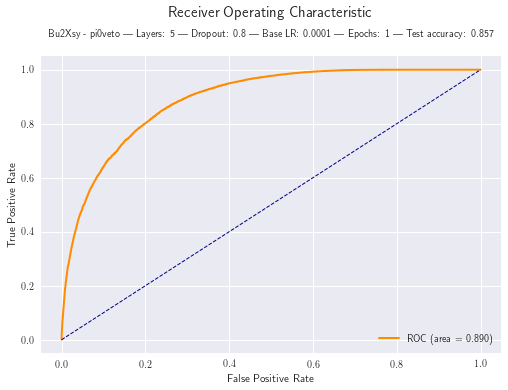

Plotting signal efficiency versus background rejection


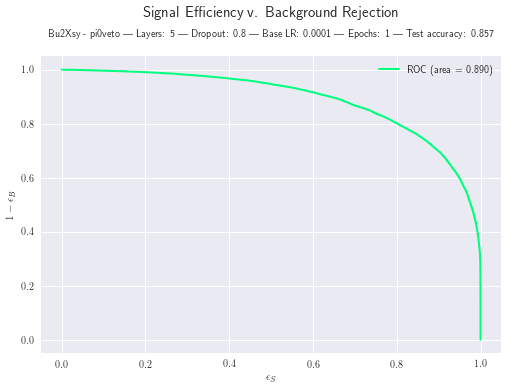

Inference complete. Duration: 42.6341 s


In [6]:
ckpt = tf.train.get_checkpoint_state(directories.checkpoints)
vDNN = vanillaDNN(config, training = False)
labels, preds, output = vDNN.predict(ckpt)